In [1]:
import pandas as pd
from print_nanny_webapp.client_events.models import PredictEvent, AlertMessage
from django.utils import timezone
from asgiref.sync import sync_to_async
import os
import uuid

import matplotlib


WARNING 2020-11-17 17:30:43,732 __init__ 28 140692777846592 Matplotlib created a temporary config/cache directory at /tmp/matplotlib-heoog1pw because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
CONFIDENCE_THRESHOLD = 0.50

LABELS = {
    1: 'nozzle',
    2: 'adhesion',
    3: 'spaghetti',
    4: 'print',
    5: 'raft',
}

FAILURES = {
    2: 'adhesion',
    3: 'spaghetti',  
}


In [3]:
import json
def dict_to_series(data):
    return pd.Series(data.values(), index=data.keys())

In [4]:
predict_events = PredictEvent.objects.all().order_by('-dt').values('id','predict_data')

df = pd.DataFrame.from_records(predict_events, index='id')
df = df['predict_data'].apply(dict_to_series)

NUM_DETECTIONS = len(df['detection_scores'].iloc[0])
print(NUM_DETECTIONS)

40


In [5]:
df = df.dropna()
df = df[['detection_classes', 'detection_scores']]
df = df.reset_index()
df = df.rename(columns={'id': 'frame_id' })

NUM_FRAMES = len(df)
df

,frame_id,detection_classes,detection_scores
0,850,"[4, 5, 1, 1, 4, 5, 4, 5, 2, 4, 5, 4, 5, 5, 5, ...","[0.73046875, 0.41796875, 0.33984375, 0.1210937..."
1,849,"[1, 5, 4, 1, 5, 4, 1, 4, 5, 5, 1, 4, 4, 4, 5, ...","[0.58203125, 0.58203125, 0.16015625, 0.0898437..."
2,848,"[1, 4, 4, 1, 5, 1, 2, 1, 4, 4, 1, 3, 1, 1, 5, ...","[0.58203125, 0.05078125, 0.03515625, 0.0273437..."
3,847,"[4, 1, 5, 1, 1, 2, 4, 1, 1, 5, 1, 4, 1, 4, 1, ...","[0.26953125, 0.16015625, 0.06640625, 0.0507812..."
4,846,"[4, 1, 2, 4, 4, 1, 1, 4, 4, 1, 1, 1, 5, 4, 3, ...","[0.33984375, 0.2109375, 0.03515625, 0.03515625..."
...,...,...,...
781,5,"[4, 1, 3, 1, 5, 3, 1, 3, 4, 3, 2, 4, 4, 3, 1, ...","[0.08984375, 0.05078125, 0.03515625, 0.0351562..."
782,4,"[4, 1, 3, 3, 1, 1, 3, 4, 1, 4, 5, 5, 3, 4, 3, ...","[0.16015625, 0.06640625, 0.06640625, 0.0507812..."
783,3,"[1, 4, 5, 1, 3, 1, 5, 5, 5, 5, 3, 3, 4, 3, 4, ...","[0.08984375, 0.08984375, 0.05078125, 0.0507812..."
784,2,"[4, 1, 5, 1, 3, 3, 4, 1, 3, 3, 1, 3, 3, 3, 3, ...","[0.16015625, 0.06640625, 0.05078125, 0.0507812..."


In [6]:
print('Explode detection_classes and detection_scores together')
df = df.set_index(['frame_id']).apply(pd.Series.explode).reset_index()

assert len(df) == NUM_FRAMES * NUM_DETECTIONS
df

Explode detection_classes and detection_scores together


,frame_id,detection_classes,detection_scores
0,850,4,0.730469
1,850,5,0.417969
2,850,1,0.339844
3,850,1,0.121094
4,850,4,0.0898438
...,...,...,...
31435,1,3,0.0117188
31436,1,1,0.0117188
31437,1,3,0.0117188
31438,1,3,0.0117188


In [7]:
print('Add labels')
df['label'] = df['detection_classes'].map(LABELS)
df


Add labels


,frame_id,detection_classes,detection_scores,label
0,850,4,0.730469,print
1,850,5,0.417969,raft
2,850,1,0.339844,nozzle
3,850,1,0.121094,nozzle
4,850,4,0.0898438,print
...,...,...,...,...
31435,1,3,0.0117188,spaghetti
31436,1,1,0.0117188,nozzle
31437,1,3,0.0117188,spaghetti
31438,1,3,0.0117188,spaghetti


In [8]:
print('Create a hierarchal index')
df = df.set_index(['frame_id', 'label'])
df

Create a hierarchal index


detection_classes detection_scores
frame_id label                                       
850      print                     4         0.730469
         raft                      5         0.417969
         nozzle                    1         0.339844
         nozzle                    1         0.121094
         print                     4        0.0898438
...                              ...              ...
1        spaghetti                 3        0.0117188
         nozzle                    1        0.0117188
         spaghetti                 3        0.0117188
         spaghetti                 3        0.0117188
         raft                      5        0.0117188

[31440 rows x 2 columns]

INFO 2020-11-17 17:30:44,435 font_manager 28 140692777846592 Generating new fontManager, this may take some time...
Distribution of confidences


array([[<AxesSubplot:title={'center':'adhesion'}>,
        <AxesSubplot:title={'center':'nozzle'}>],
       [<AxesSubplot:title={'center':'print'}>,
        <AxesSubplot:title={'center':'raft'}>],
       [<AxesSubplot:title={'center':'spaghetti'}>, <AxesSubplot:>]],
      dtype=object)

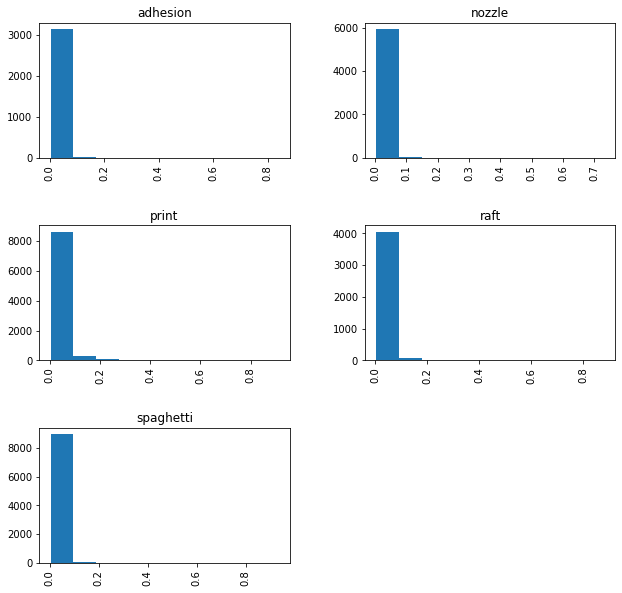

In [9]:
print(f'Distribution of confidences')
df['detection_scores'].hist(by='label', figsize=(10,10))

Distribution of confidences > 0.5


array([[<AxesSubplot:title={'center':'adhesion'}>,
        <AxesSubplot:title={'center':'nozzle'}>],
       [<AxesSubplot:title={'center':'print'}>,
        <AxesSubplot:title={'center':'raft'}>],
       [<AxesSubplot:title={'center':'spaghetti'}>, <AxesSubplot:>]],
      dtype=object)

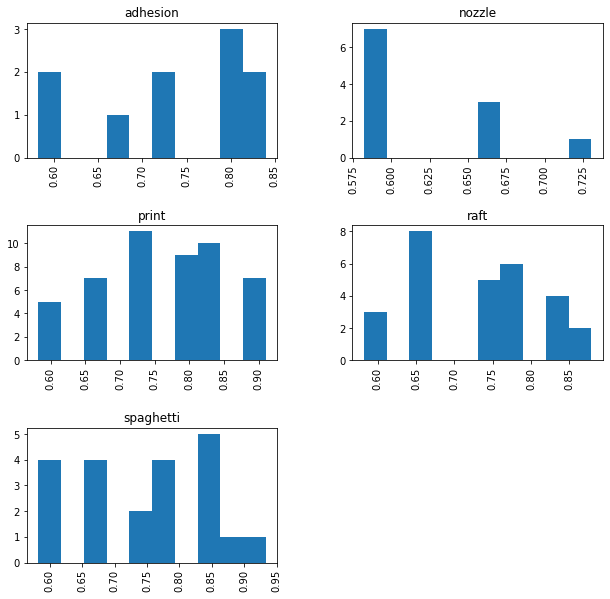

In [10]:
print(f'Distribution of confidences > {CONFIDENCE_THRESHOLD}')
df[df['detection_scores'] > CONFIDENCE_THRESHOLD]['detection_scores'].hist(by='label', figsize=(10,10))

Distribution of confidence scores > THRESHOLD, FAILURE vs. OK


array([<AxesSubplot:title={'center':'FAILURE'}>,
       <AxesSubplot:title={'center':'NEUTRAL'}>], dtype=object)

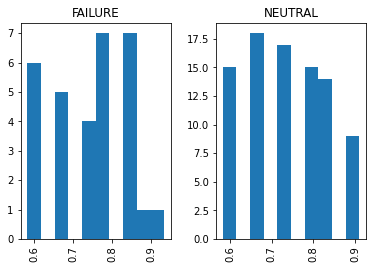

In [11]:
print('Distribution of confidence scores > THRESHOLD, FAILURE vs. OK')
df[df['detection_scores'] > CONFIDENCE_THRESHOLD]['detection_scores'].hist(by=lambda x: 'FAILURE' if x[1] in FAILURES.values() else 'NEUTRAL' )


In [12]:
print('Frames where at least 1 type of failure is confidently detected')

mask = (df['detection_scores'] > CONFIDENCE_THRESHOLD) & (df['detection_classes'].isin(FAILURES))

fail_df = df[mask]

fail_df

Frames where at least 1 type of failure is confidently detected


,,detection_classes,detection_scores
frame_id,label,,
841,spaghetti,3,0.933594
840,spaghetti,3,0.839844
839,spaghetti,3,0.878906
838,spaghetti,3,0.839844
837,adhesion,2,0.839844
836,adhesion,2,0.730469
834,adhesion,2,0.839844
833,spaghetti,3,0.660156
813,spaghetti,3,0.730469


In [13]:
print('Percent of frames where at least 1 type of failure is confidently detected')
(len(fail_df) / NUM_FRAMES) * 100

Percent of frames where at least 1 type of failure is confidently detected


3.9440203562340965

In [14]:
print('Frames where at least 1 type of neutral is confidently detected')

mask = (df['detection_scores'] > CONFIDENCE_THRESHOLD) & (~df['detection_classes'].isin(FAILURES))

neutral_df = df[mask]

neutral_df 

Frames where at least 1 type of neutral is confidently detected


detection_classes detection_scores
frame_id label                                    
850      print                  4         0.730469
849      nozzle                 1         0.582031
         raft                   5         0.582031
848      nozzle                 1         0.582031
840      print                  4         0.582031
...                           ...              ...
740      nozzle                 1         0.582031
739      print                  4         0.730469
         raft                   5         0.582031
738      print                  4         0.660156
688      print                  4         0.839844

[88 rows x 2 columns]

In [15]:
print('Percent of frames where at least 1 type of neutral (print, raft, nozzle) is confidently detected')
(len(neutral_df ) / NUM_FRAMES) * 100

Percent of frames where at least 1 type of neutral (print, raft, nozzle) is confidently detected


11.195928753180661

In [16]:
print('Ratio of frames with at least 1 failure detected : frames with at least 1 neutral detected')

len(fail_df) / (len(neutral_df ))

Ratio of frames with at least 1 failure detected : frames with at least 1 neutral detected


0.3522727272727273

In [17]:
tuple(df[df['detection_scores'] > CONFIDENCE_THRESHOLD].groupby(level='label').size().items())

(('adhesion', 10),
 ('nozzle', 11),
 ('print', 49),
 ('raft', 28),
 ('spaghetti', 21))

In [27]:
fail_df.groupby('frame_id').size()
neutral_df.groupby('frame_id').size()

confident_df = df[df['detection_scores'] > CONFIDENCE_THRESHOLD]

predict_event = PredictEvent.objects.last()
#/ len(neutral_df.groupby('frame_id'))
predict_event.files.annotated_image


def send_email_notification(fail_df, ratio=0.55):
    frame_ids = [frame_id for frame_id, _ in fail_df.index]
    predict_events = PredictEvent.objects.filter(
        id__in=frame_ids 
    ).order_by('dt').all()

    print_job = predict_event[0].print_job.gcode_file.name

    alert_message = AlertMessage.objects.filter(
        print_job=print_job.id
    ).first()

    if alert_message is not None:
        logging.warning('Alert for print job {print_job} already sent at {alert_message.created_dt}, skipping')
        return

    images = [ 
        imageio.imread(event.file.annotated_image.file.url)
    ]

    buff = BytesIO
    buff.name = uuid.4()
    gif = imageio.imsave(buff, images, fps=60)

    alert_message = AlertMessage(
        user,
        print_job,
        file=gif,
        dataframe=fail_df.to_dict()
    )

    merge_data = {
        'RATIO': '{:.2%}'.format(ratio),
        'GCODE_FILE': print_job.gcode_file.name,
        'VIDEO_URL': alert_message.video.url,
        'STOP_URL': f'http://localhost/feedback/{alert_message.id}?action=stop_print',
        'SILENCE_URL': f'http://localhost/feedback/{alert_message.id}?action=silence'
        'RESUME_URL': f'http://localhost/feedback/{alert_message.id}?action=resume'
        'FIRST_NAME': print_job.user.first_name or 'Maker',
    }

    subject = render_to_string("message_subject.txt", merge_data).strip()
    text_body = render_to_string("message_body.txt", merge_data)
    html_body = render_to_string("message_body.html", merge_data)

    message = AnymailMessage(
        subject=subject,
        body=text_body
        to=[predict_events[0].user.email],
        tags=["default-print-alert"],  # Anymail extra in constructor
    )
    message.attach_alternative(html_body, 'text/html')


<ImageFieldFile: annotated_image_YL9laZc.jpg>